In [3]:
import os, time, math
import torch
from torch import optim, nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# sample data
raw_data = []
with open('/content/drive/MyDrive/lab126share/data/lstm-label.txt', 'r') as f:
  lines = f.readlines()[:120]
  for line in lines:
    attrs_num = line.rstrip().split(': ')[1].split(' ')
    atrrs_num = [int(x) for x in attrs_num]
    raw_data.append(attrs_num)
all_data = np.array(raw_data, dtype='float32')
all_data = all_data.T
print("all_data[0]:", all_data[0], all_data.shape)

# 相对化
trend_data3, trend_data5 = [], []
for data in all_data:
  row = []
  for i in range(len(data) - 3):
    row.append(data[i+3] - (data[i]+data[i+1]+data[i+2])/3)
  trend_data3.append(row)

for data in all_data:
  row = []
  for i in range(len(data) - 5):
    row.append(data[i+5] - (data[i]+data[i+1]+data[i+2]+data[i+3]+data[i+4])/5)
  trend_data5.append(row)

trend_data3 = np.array(trend_data3, dtype='float32')
trend_data5 = np.array(trend_data5, dtype='float32')
print("trend_data3:", trend_data3[0], trend_data3.shape)
print("trend_data5:", trend_data5[0], trend_data5.shape)
## 均值化
min_trend3 = trend_data3.min(axis=1)
max_trend3 = trend_data3.max(axis=1)
trend_norm3 = ((trend_data3 + np.reshape(min_trend3, (30, 1))) / np.reshape(-min_trend3, (30, 1))) + 1

all_data[0]: [520. 520. 545. 510. 479. 525. 540. 530. 506. 571. 516. 474. 499. 501.
 491. 548. 529. 492. 464. 449. 546. 529. 570. 588. 516. 461. 482. 535.
 510. 496. 563. 515. 516. 521. 517. 516. 516. 516. 515. 515. 515. 492.
 482. 401. 250. 393. 382. 341. 333. 402. 408. 436. 407. 365. 345. 430.
 433. 389. 413. 393. 347. 354. 405. 383. 364. 423. 401. 336. 324. 339.
 340. 346. 376. 332. 316. 288. 339. 324. 328. 313. 303. 294. 300. 264.
 333. 310. 295. 281. 268. 264. 316. 306. 294. 308. 298. 254. 343. 308.
 368. 376. 331. 367. 354. 349. 446. 502. 479. 428. 424. 415. 294. 314.
 308. 224. 229. 207. 202. 203. 213. 201.] (30, 120)
trend_data3: [ -18.333334    -46.           13.666667     35.333332     15.333333
  -25.666666     45.666668    -19.666666    -57.          -21.333334
    4.6666665    -0.33333334   51.           15.666667    -30.666666
  -59.          -46.           77.666664     42.666668     62.
   39.666668    -46.333332    -97.          -39.666668     48.666668
   17.333334   

In [ ]:
# create_dataset
def create_dataset(data, days_for_train=5, days_to_predict=1) -> (np.array, np.array):
  dataset_x, dataset_y = [], []
  for i in range(len(data)-days_for_train):
    _x = data[i:(i+days_for_train)]
    dataset_x.append(_x)
    dataset_y.append(data[i+days_for_train+days_to_predict-1]) # 更改days_to_predict可以预测N天后的
  return (np.array(dataset_x), np.array(dataset_y))

# def create_train_data(all_data, days_for_train, train_size):
#   for data in all_data[:, :train_size+days_for_train]:
#     dataset_x, dataset_y = create_dataset(data, days_for_train)
#     train_x = dataset_x.reshape(-1, 1, days_for_train)
#     train_y = dataset_y.reshape(-1, 1, 1)
#     train_x = torch.from_numpy(train_x)
#     train_y = torch.from_numpy(train_y)
#     yield train_x, train_y
  
def denorm(data, minimum):
  return (data - 1) * (-minimum) - minimum

In [ ]:
# practice lstm of pytorch
class LSTM_Regression(nn.Module):
  def __init__(self, input_size, hidden_size, output_size=1, num_layers=2): #【output_size：输出序列长度可以改变】
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(0.5) 

  def forward(self, _x):
    x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
    x = self.dropout(x)
    s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
    x = x.view(s*b, h)
    x = self.fc(x)
    x = x.view(s, b, -1)  # 把形状改回来
    return x

# 训练(单日)

In [ ]:
# trend3
DAYS_FOR_TRAIN = 3
DAYS_TO_PREDICT = 1
NUM_LAYERS = 2
HIDDEN_SIZE = 8

days_look_back = 5

PATH = f'/content/drive/MyDrive/lab126share/lstm_para/model{days_look_back}_{DAYS_FOR_TRAIN}{NUM_LAYERS}{HIDDEN_SIZE}'
if not os.path.exists(PATH):
  os.mkdir(PATH)

# -----------------------------------------------------------------------------
## 数据预处理
# data load
raw_data = []
with open(input_path, 'r') as f:
  lines = f.readlines()[:120]
  for line in lines:
    attrs_num = line.rstrip().split(': ')[1].split(' ')
    atrrs_num = [int(x) for x in attrs_num]
    raw_data.append(attrs_num)
all_data = np.array(raw_data, dtype='float32')
all_data = all_data.T

# 相对化
trend_data = []
for data in all_data:
  row = []
  for i in range(len(data) - days_look_back):
    avg = 0
    for j in range(days_look_back):
      avg += data[i+j]
    avg /= days_look_back
    row.append(data[i+days_look_back] - avg)
  trend_data.append(row)
trend_data = np.array(trend_data, dtype='float32')

## 均值化
min_trend = trend_data.min(axis=1)
max_trend = trend_data.max(axis=1)
trend_norm = ((trend_data3 + np.reshape(min_trend3, (30, 1))) / np.reshape(-min_trend3, (30, 1))) + 1
with open(os.path.join(PATH, f'min_trend.txt'), 'w') as f:
  f.write(str(list(min_trend)))
  f.close()

## 不均值化
# PATH = f'model3_{DAYS_FOR_TRAIN}{NUM_LAYERS}{HIDDEN_SIZE}_normoff'
# trend_norm3 = trend_data3
# trend_norm3[0], trend_norm3.shape

TRAIN_SIZE = 90
epochs = 500
lr = 1e-2

attributes = ['floral', 'striped', 'plaid', 'leopard', 'camo', 'graphic',
        'crew neck', 'square neck', 'v-neck',
        'maxi dress', 'midi dress', 'mini dress',
        'denim', 'knit', 'faux leather', 'cotton', 'chiffon', 'satin',
        'mesh', 'ruched', 'cutout', 'lace', 'frayed', 'wrap',
        'tropical', 'peasant', 'swim', 'bikini', 'active', 'cargo']

attr_train_result, attr_test_result = dict(), dict()
for index in range(30):
  data_x, data_y = create_dataset(trend_norm3[index], days_for_train=DAYS_FOR_TRAIN, days_to_predict=DAYS_TO_PREDICT)
  train_x = torch.from_numpy(data_x[:TRAIN_SIZE].reshape(-1, 1, DAYS_FOR_TRAIN))
  train_y = torch.from_numpy(data_y[:TRAIN_SIZE].reshape(-1, 1, 1))
  test_x = torch.from_numpy(data_x[TRAIN_SIZE:].reshape(-1, 1, DAYS_FOR_TRAIN))
  test_y = torch.from_numpy(data_y[TRAIN_SIZE:].reshape(-1, 1, 1))

  model = LSTM_Regression(DAYS_FOR_TRAIN, HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS)
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  ### 转换到gpu
  # model, loss_function = model.to(device), loss_function.to(device)
  # train_x, train_y = train_x.to(device), train_y.to(device)
  # test_x, test_y = test_x.to(device), test_y.to(device)
  
  attr_train_result[attributes[index]] = []
  attr_test_result[attributes[index]] = []
  for i in range(epochs):
    model.train()
    out = model(train_x)
    loss = loss_function(out, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1) % 10 == 0:
      model.eval()
      test_out = model(test_x)
      test_loss = loss_function(test_out, test_y)
      print('Attribute: {}, Epoch: {}, Loss:{:.5f}, Test Loss:{:.5f}'.format(attributes[index], i+1, loss.item(), test_loss.item()))
      torch.save(model.state_dict(), os.path.join(PATH, f'{attributes[index]}_epoch_{i+1}.pth'))
      attr_train_result[attributes[index]].append(loss.item())
      attr_test_result[attributes[index]].append(test_loss.item())

for k, v in attr_test_result.items():
  print(k, [round(x, 4) for x in v])

with open(os.path.join(PATH, 'attr_result.txt'), 'w') as f:
  f.write(str((attr_train_result, attr_test_result)))
  f.close()

NameError: ignored

# 训练（多日）

In [ ]:
import os, time, math
import torch
from torch import optim, nn
 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

# -----------------------------------------------------------------------------
# 模型参数
DAYS_FOR_TRAIN = 10
DAYS_TO_PREDICT = 7
NUM_LAYERS = 2
HIDDEN_SIZE = 8
TRAIN_SIZE = 90

epochs = 500
lr = 1e-2

attributes = ['floral', 'striped', 'plaid', 'leopard', 'camo', 'graphic',
        'crew neck', 'square neck', 'v-neck',
        'maxi dress', 'midi dress', 'mini dress',
        'denim', 'knit', 'faux leather', 'cotton', 'chiffon', 'satin',
        'mesh', 'ruched', 'cutout', 'lace', 'frayed', 'wrap',
        'tropical', 'peasant', 'swim', 'bikini', 'active', 'cargo']

attr_num = len(attributes)
input_path = '/content/drive/MyDrive/lab126share/data/lstm-label.txt'
days_look_back = 5
output_size = 1

PATH = f'/content/drive/MyDrive/lab126share/lstm_para/model{days_look_back}_{DAYS_FOR_TRAIN}{NUM_LAYERS}{HIDDEN_SIZE}_{DAYS_TO_PREDICT}'
PATH_BEST = f'/content/drive/MyDrive/lab126share/lstm_para/model{days_look_back}_{DAYS_FOR_TRAIN}{NUM_LAYERS}{HIDDEN_SIZE}_{DAYS_TO_PREDICT}_best'
if not os.path.exists(PATH):
  os.mkdir(PATH)
if not os.path.exists(PATH_BEST):
  os.mkdir(PATH_BEST)

# -----------------------------------------------------------------------------
## 数据预处理
# data load
raw_data = []
with open(input_path, 'r') as f:
  lines = f.readlines()[:120]
  for line in lines:
    attrs_num = line.rstrip().split(': ')[1].split(' ')
    atrrs_num = [int(x) for x in attrs_num]
    raw_data.append(attrs_num)
all_data = np.array(raw_data, dtype='float32')
all_data = all_data.T

# 相对化
trend_data = []
for data in all_data:
  row = []
  for i in range(len(data) - days_look_back):
    avg = 0
    for j in range(days_look_back):
      avg += data[i+j]
    avg /= days_look_back
    row.append(data[i+days_look_back] - avg)
  trend_data.append(row)
trend_data = np.array(trend_data, dtype='float32')

# 均值化
min_trend = trend_data.min(axis=1)
max_trend = trend_data.max(axis=1)
trend_norm = ((trend_data + np.reshape(min_trend, (attr_num, 1))) / np.reshape(-min_trend, (attr_num, 1))) + 1
with open(os.path.join(PATH, f'min_trend.txt'), 'w') as f:
  f.write(str(list(min_trend)))
  f.close()
with open(os.path.join(PATH_BEST, f'min_trend.txt'), 'w') as f:
  f.write(str(list(min_trend)))
  f.close()
# 反均值化函数（展示用）
def denorm(data, minimum):
  return (data - 1) * (-minimum) - minimum

# create_dataset
def create_dataset(data, days_for_train=5, days_to_predict=1) -> (np.array, np.array): # 更改days_to_predict可以预测N天后的
  dataset_x, dataset_y = [], []
  for i in range(len(data)-days_for_train-days_to_predict+1):
    _x = data[i:(i+days_for_train)]
    dataset_x.append(_x)
    dataset_y.append([])
    for j in range(days_to_predict):
      dataset_y[i].append(data[i+days_for_train+j]) 
  return (np.array(dataset_x), np.array(dataset_y).T)

# -----------------------------------------------------------------------------
# LSTM预测
# practice lstm of pytorch
class LSTM_Regression(nn.Module):
  def __init__(self, input_size, hidden_size, output_size=1, num_layers=2): #【output_size：输出序列长度可以改变】
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(0.5) 

  def forward(self, _x):
    print(_x[0])
    print(_x.shape)
    x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
    print(x[0])
    print(x.shape)
    x = self.dropout(x)
    s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
    x = x.view(s*b, h)
    x = self.fc(x)
    x = x.view(s, b, -1)  # 把形状改回来
    return x

for day in range(DAYS_TO_PREDICT):
  attr_train_result, attr_test_result = dict(), dict()
  for index in range(len(attributes)):
    data_x, data_y = create_dataset(trend_norm[index], days_for_train=DAYS_FOR_TRAIN, days_to_predict=DAYS_TO_PREDICT)
    train_x = torch.from_numpy(data_x[:TRAIN_SIZE].reshape(-1, 1, DAYS_FOR_TRAIN))
    train_y = torch.from_numpy(data_y[day][:TRAIN_SIZE].reshape(-1, 1, 1))
    test_x = torch.from_numpy(data_x[TRAIN_SIZE:].reshape(-1, 1, DAYS_FOR_TRAIN))
    test_y = torch.from_numpy(data_y[day][TRAIN_SIZE:].reshape(-1, 1, 1))

    model = LSTM_Regression(DAYS_FOR_TRAIN, HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    ### 转换到gpu
    # model, loss_function = model.to(device), loss_function.to(device)
    # train_x, train_y = train_x.to(device), train_y.to(device)
    # test_x, test_y = test_x.to(device), test_y.to(device)
    
    attr_train_result[attributes[index]] = []
    attr_test_result[attributes[index]] = []
    for i in range(epochs):
      model.train()
      out = model(train_x)
      loss = loss_function(out, train_y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      if (i+1) % 10 == 0:
        model.eval()
        test_out = model(test_x)
        test_loss = loss_function(test_out, test_y)
        print('Attribute: {}, Epoch: {}, Loss:{:.5f}, Test Loss:{:.5f}'.format(attributes[index], i+1, loss.item(), test_loss.item()))
        torch.save(model.state_dict(), os.path.join(PATH, f'{attributes[index]}_day{day}_epoch_{i+1}.pth'))
        attr_train_result[attributes[index]].append(loss.item())
        attr_test_result[attributes[index]].append(test_loss.item())

  for k, v in attr_test_result.items():
    print(k, [round(x, 4) for x in v])

  print("Model choosing: day{}".format(day))
  for index in range(30):
    epoch = attr_test_result[attributes[index]].index(min(attr_test_result[attributes[index]]))
    epoch = (epoch + 1) * 10
    if epoch < 70:
      epoch = 200
    print('Attribute: {}, BEST_Epoch: {}'.format(attributes[index], epoch))
    with open(os.path.join(PATH, f'{attributes[index]}_day{day}_epoch_{epoch}.pth'), 'rb') as src:
      with open(os.path.join(PATH_BEST, f'{attributes[index]}_day{day}.pth'), 'wb') as des:
        des.write(src.read())
        des.close()
      src.close()
  
  with open(os.path.join(PATH, f'attr_result_day{day}.txt'), 'w') as f:
    f.write(str((attr_train_result, attr_test_result)))
    f.close()
  with open(os.path.join(PATH_BEST, f'attr_result_day{day}.txt'), 'w') as f:
    f.write(str((attr_train_result, attr_test_result)))
    f.close()




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
tensor([[ 0.0442,  0.1048,  0.0442, -0.0468,  0.2381, -0.0797, -0.2537, -0.0883,
         -0.0528, -0.0918]])
torch.Size([90, 1, 10])
tensor([[ 0.0435,  0.0880,  0.0605,  0.1010, -0.0190, -0.0093, -0.0618,  0.1259]],
       grad_fn=<SelectBackward>)
torch.Size([90, 1, 8])
tensor([[ 0.0442,  0.1048,  0.0442, -0.0468,  0.2381, -0.0797, -0.2537, -0.0883,
         -0.0528, -0.0918]])
torch.Size([90, 1, 10])
tensor([[ 0.0489,  0.0957,  0.0659,  0.0944, -0.0142, -0.0060, -0.0528,  0.1334]],
       grad_fn=<SelectBackward>)
torch.Size([90, 1, 8])
tensor([[ 0.0442,  0.1048,  0.0442, -0.0468,  0.2381, -0.0797, -0.2537, -0.0883,
         -0.0528, -0.0918]])
torch.Size([90, 1, 10])
tensor([[ 0.0550,  0.1039,  0.0711,  0.0882, -0.0091, -0.0024, -0.0440,  0.1408]],
       grad_fn=<SelectBackward>)
torch.Size([90, 1, 8])
tensor([[ 0.0442,  0.1048,  0.0442, -0.0468,  0.2381

KeyboardInterrupt: ignored

# 训练（多日R)

In [ ]:
import os, time, math
import torch
from torch import optim, nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 模型参数
DAYS_FOR_TRAIN = 10
DAYS_TO_PREDICT = 7
NUM_LAYERS = 2
HIDDEN_SIZE = 8
TRAIN_SIZE = 90

epochs = 500
lr = 1e-2

attributes = ['floral', 'striped', 'plaid', 'leopard', 'camo', 'graphic',
        'crew neck', 'square neck', 'v-neck',
        'maxi dress', 'midi dress', 'mini dress',
        'denim', 'knit', 'faux leather', 'cotton', 'chiffon', 'satin',
        'mesh', 'ruched', 'cutout', 'lace', 'frayed', 'wrap',
        'tropical', 'peasant', 'swim', 'bikini', 'active', 'cargo']

attr_num = len(attributes)
input_path = '/content/drive/MyDrive/lab126share/data/lstm-label.txt'
days_look_back = 5
output_size = 1

PATH = f'/content/drive/MyDrive/lab126share/lstm_para/model{days_look_back}_{DAYS_FOR_TRAIN}{NUM_LAYERS}{HIDDEN_SIZE}_{DAYS_TO_PREDICT}R'
PATH_BEST = f'/content/drive/MyDrive/lab126share/lstm_para/model{days_look_back}_{DAYS_FOR_TRAIN}{NUM_LAYERS}{HIDDEN_SIZE}_{DAYS_TO_PREDICT}R_best'
if not os.path.exists(PATH):
  os.mkdir(PATH)
if not os.path.exists(PATH_BEST):
  os.mkdir(PATH_BEST)

# -----------------------------------------------------------------------------
## 数据预处理
# data load
def load_data(path):
    raw_data = []
    with open(path, 'r') as f:
      lines = f.readlines()[:120]
      for line in lines:
        attrs_num = line.rstrip().split(': ')[1].split(' ')
        attrs_num = [int(x) for x in attrs_num]
        raw_data.append(attrs_num)
    all_data = np.array(raw_data, dtype='float32')
    all_data = all_data.T
    return all_data
# 相对化
trend_data = []
for data in all_data:
  row = []
  for i in range(len(data) - days_look_back):
    avg = 0
    for j in range(days_look_back):
      avg += data[i+j]
    avg /= days_look_back
    row.append((data[i+days_look_back]-avg)/avg)
  trend_data.append(row)
trend_data = np.array(trend_data, dtype='float32')
trend_norm = trend_data

# # 均值化
# min_trend = trend_data.min(axis=1)
# max_trend = trend_data.max(axis=1)
# trend_norm = ((trend_data + np.reshape(min_trend, (attr_num, 1))) / np.reshape(-min_trend, (attr_num, 1))) + 1
# with open(os.path.join(PATH, f'min_trend.txt'), 'w') as f:
#   f.write(str(list(min_trend)))
#   f.close()
# with open(os.path.join(PATH_BEST, f'min_trend.txt'), 'w') as f:
#   f.write(str(list(min_trend)))
#   f.close()
# # 反均值化函数（展示用）
# def denorm(data, minimum):
#   return (data - 1) * (-minimum) - minimum

# create_dataset
def create_dataset(data, days_for_train=5, days_to_predict=1) -> (np.array, np.array): # 更改days_to_predict可以预测N天后的
  dataset_x, dataset_y = [], []
  for i in range(len(data)-days_for_train-days_to_predict+1):
    _x = data[i:(i+days_for_train)]
    dataset_x.append(_x)
    dataset_y.append([])
    for j in range(days_to_predict):
      dataset_y[i].append(data[i+days_for_train+j])
  return (np.array(dataset_x), np.array(dataset_y).T)

# -----------------------------------------------------------------------------
# LSTM预测
# practice lstm of pytorch
class LSTM_Regression(nn.Module):
  def __init__(self, input_size, hidden_size, output_size=1, num_layers=2): #【output_size：输出序列长度可以改变】
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(0.5)

  def forward(self, _x):
    x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
    # x = self.dropout(x)
    s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
    x = x.view(s*b, h)
    x = self.fc(x)
    x = x.view(s, b, -1)  # 把形状改回来
    return x

for day in range(DAYS_TO_PREDICT):
  attr_train_result, attr_test_result = dict(), dict()
  for index in range(len(attributes)):
    data_x, data_y = create_dataset(trend_norm[index], days_for_train=DAYS_FOR_TRAIN, days_to_predict=DAYS_TO_PREDICT)
    train_x = torch.from_numpy(data_x[:TRAIN_SIZE].reshape(-1, 1, DAYS_FOR_TRAIN))
    train_y = torch.from_numpy(data_y[day][:TRAIN_SIZE].reshape(-1, 1, 1))
    test_x = torch.from_numpy(data_x[TRAIN_SIZE:].reshape(-1, 1, DAYS_FOR_TRAIN))
    test_y = torch.from_numpy(data_y[day][TRAIN_SIZE:].reshape(-1, 1, 1))

    model = LSTM_Regression(DAYS_FOR_TRAIN, HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    ### 转换到gpu
    # model, loss_function = model.to(device), loss_function.to(device)
    # train_x, train_y = train_x.to(device), train_y.to(device)
    # test_x, test_y = test_x.to(device), test_y.to(device)

    attr_train_result[attributes[index]] = []
    attr_test_result[attributes[index]] = []
    for i in range(epochs):
      model.train()
      out = model(train_x)
      loss = loss_function(out, train_y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      if (i+1) % 10 == 0:
        model.eval()
        test_out = model(test_x)
        test_loss = loss_function(test_out, test_y)
        if (i+1) % 100 == 0:
          print('Attribute: {}, Epoch: {}, Loss:{:.5f}, Test Loss:{:.5f}'.format(attributes[index], i+1, loss.item(), test_loss.item()))
        torch.save(model.state_dict(), os.path.join(PATH, f'{attributes[index]}_day{day}_epoch_{i+1}.pth'))
        attr_train_result[attributes[index]].append(loss.item())
        attr_test_result[attributes[index]].append(test_loss.item())

  for k, v in attr_test_result.items():
    print(k, [round(x, 4) for x in v])

  print("Model choosing: day{}".format(day))
  for index in range(30):
    epoch = attr_test_result[attributes[index]].index(min(attr_test_result[attributes[index]]))
    epoch = (epoch + 1) * 10
    if epoch < 70:
      epoch = 200
    print('Attribute: {}, BEST_Epoch: {}'.format(attributes[index], epoch))
    with open(os.path.join(PATH, f'{attributes[index]}_day{day}_epoch_{epoch}.pth'), 'rb') as src:
      with open(os.path.join(PATH_BEST, f'{attributes[index]}_day{day}.pth'), 'wb') as des:
        des.write(src.read())
        des.close()
      src.close()

  with open(os.path.join(PATH, f'attr_result_day{day}.txt'), 'w') as f:
    f.write(str((attr_train_result, attr_test_result)))
    f.close()
  with open(os.path.join(PATH_BEST, f'attr_result_day{day}.txt'), 'w') as f:
    f.write(str((attr_train_result, attr_test_result)))
    f.close()




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Attribute: floral, Epoch: 100, Loss:0.01017, Test Loss:0.05381
Attribute: floral, Epoch: 200, Loss:0.00696, Test Loss:0.05878
Attribute: floral, Epoch: 300, Loss:0.00524, Test Loss:0.07242
Attribute: floral, Epoch: 400, Loss:0.00508, Test Loss:0.08150
Attribute: floral, Epoch: 500, Loss:0.00387, Test Loss:0.08594
Attribute: striped, Epoch: 100, Loss:0.01285, Test Loss:0.04547
Attribute: striped, Epoch: 200, Loss:0.00739, Test Loss:0.10024
Attribute: striped, Epoch: 300, Loss:0.00607, Test Loss:0.19848
Attribute: striped, Epoch: 400, Loss:0.00326, Test Loss:0.24927
Attribute: striped, Epoch: 500, Loss:0.00284, Test Loss:0.22434
Attribute: plaid, Epoch: 100, Loss:0.00903, Test Loss:0.00316
Attribute: plaid, Epoch: 200, Loss:0.00634, Test Loss:0.00223
Attribute: plaid, Epoch: 300, Loss:0.00577, Test Loss:0.00191
Attribute: plaid, Epoch: 400, Loss:0.00306, Test L

# 测试

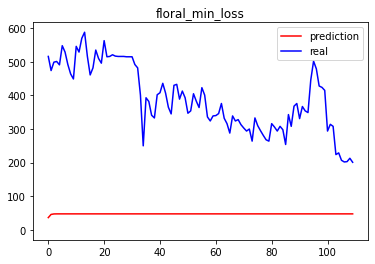

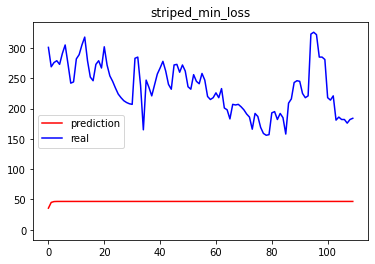

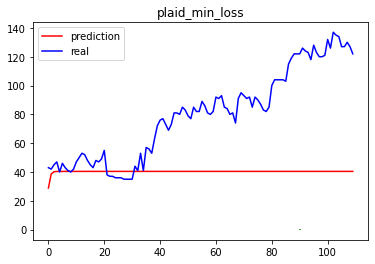

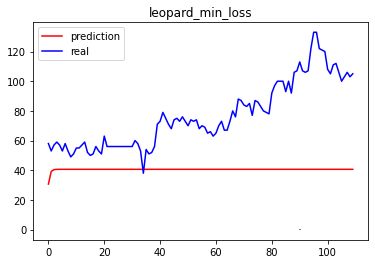

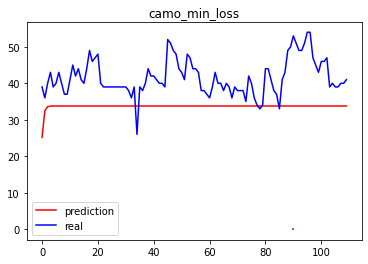

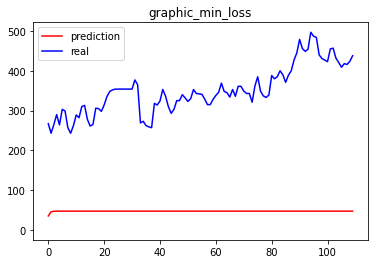

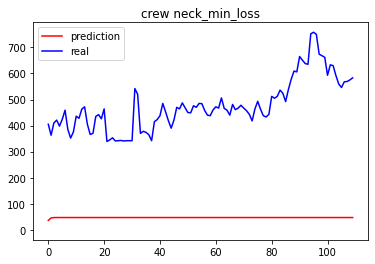

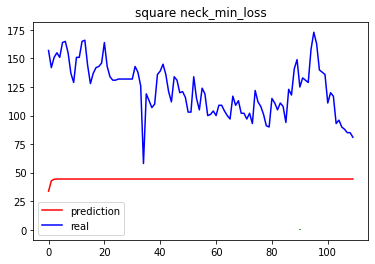

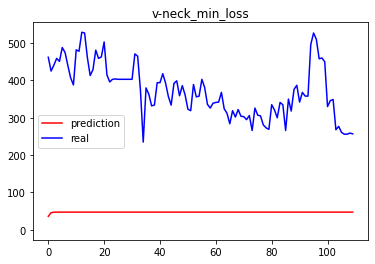

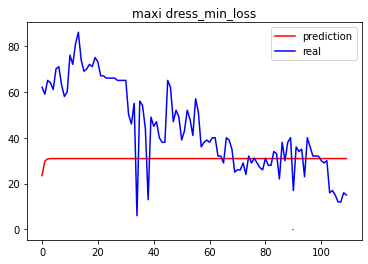

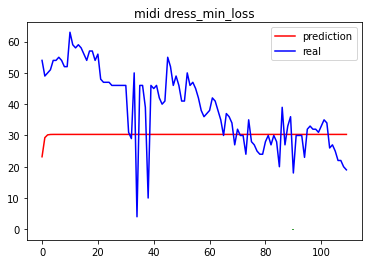

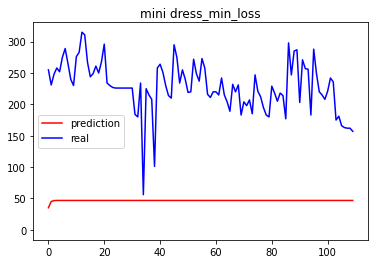

In [8]:
DAYS_FOR_TRAIN = 10
DAYS_TO_PREDICT = 1
NUM_LAYERS = 2
HIDDEN_SIZE = 8
TRAIN_SIZE = 90
PATH = 'model_test'

attributes = ['floral', 'striped', 'plaid', 'leopard', 'camo', 'graphic',
        'crew neck', 'square neck', 'v-neck',
        'maxi dress', 'midi dress', 'mini dress',
        'denim', 'knit', 'faux leather', 'cotton', 'chiffon', 'satin',
        'mesh', 'ruched', 'cutout', 'lace', 'frayed', 'wrap',
        'tropical', 'peasant', 'swim', 'bikini', 'active', 'cargo']

def load_data(path):
    raw_data = []
    with open(path, 'r') as f:
        lines = f.readlines()[:120]
        for line in lines:
            attrs_num = line.rstrip().split(': ')[1].split(' ')
            attrs_num = [int(x) for x in attrs_num]
            raw_data.append(attrs_num)
    all_data = np.array(raw_data, dtype='float32')
    all_data = all_data.T
    return all_data

# create_dataset
def create_dataset(data, days_for_train=5, days_to_predict=1) -> (np.array, np.array): # 更改days_to_predict可以预测N天后的
  dataset_x, dataset_y = [], []
  for i in range(len(data)-days_for_train-days_to_predict+1):
    _x = data[i:(i+days_for_train)]
    dataset_x.append(_x)
    dataset_y.append([])
    for j in range(days_to_predict):
      dataset_y[i].append(data[i+days_for_train+j])
  return (np.array(dataset_x), np.array(dataset_y).T)

class LSTM_Regression(nn.Module):
  def __init__(self, input_size, hidden_size, output_size=1, num_layers=2): #【output_size：输出序列长度可以改变】
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(0.5)

  def forward(self, _x):
    x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
    # x = self.dropout(x)
    s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
    x = x.view(s*b, h)
    x = self.fc(x)
    x = x.view(s, b, -1)  # 把形状改回来
    return x

trend_data = load_data('data/lstm-label.txt')
for index in range(12):
    data_x, data_y = create_dataset(trend_data[index], days_for_train=DAYS_FOR_TRAIN)
    data_y = data_y.reshape(-1)
    # data_y = denorm(data_y, min_trend[index])
    all_data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
    all_data_x = torch.from_numpy(all_data_x)

    pred_model = torch.load(os.path.join(PATH, f'{attributes[index]}_day0.pt'), map_location='cpu')

    pred_model.eval()
    pred_test = pred_model(all_data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
    pred_test = pred_test.cpu().view(-1).data.numpy()
    # pred_test = denorm(pred_test, min_trend[index])

    plt.plot(pred_test, 'r', label='prediction')
    plt.plot(data_y, 'b', label='real')
    plt.plot((TRAIN_SIZE, TRAIN_SIZE), (-0.2, 0.2), 'g--')
    plt.legend(loc='best')
    plt.title(f'{attributes[index]}_min_loss')
    plt.show()

    # # 100 epoch
    # for epoch in [100, 200, 500]:
    #   pred_model.load_state_dict(torch.load(os.path.join(PATH, f'{attributes[index]}_day0_epoch_{epoch}.pth')))
    #   pred_model.eval()
    #   pred_test = pred_model(all_data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
    #   pred_test = pred_test.cpu().view(-1).data.numpy()
    #   # pred_test = denorm(pred_test, min_trend[index])

    #   plt.plot(pred_test, 'r', label='prediction')
    #   plt.plot(data_y, 'b', label='real')
    #   plt.plot((TRAIN_SIZE, TRAIN_SIZE), (-0.2, 0.2), 'g--')
    #   plt.legend(loc='best')
    #   plt.title(f'{attributes[index]}_epoch_{epoch}')
    #   plt.show()

# 模型选择及本地化

## 模型选择（单日）

In [ ]:
attributes = ['floral', 'striped', 'plaid', 'leopard', 'camo', 'graphic',
        'crew neck', 'square neck', 'v-neck',
        'maxi dress', 'midi dress', 'mini dress',
        'denim', 'knit', 'faux leather', 'cotton', 'chiffon', 'satin',
        'mesh', 'ruched', 'cutout', 'lace', 'frayed', 'wrap',
        'tropical', 'peasant', 'swim', 'bikini', 'active', 'cargo']
PATH = '/content/drive/MyDrive/lab126share/lstm_para/model3_5328/'
PATH_DES = '/content/drive/MyDrive/lab126share/lstm_para/model3_5328_best'
if not os.path.exists(PATH_DES):
  os.mkdir(PATH_DES)

pred_model = LSTM_Regression(DAYS_FOR_TRAIN, HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS)
# 模型选择
with open(os.path.join(PATH, 'attr_result.txt'), 'r') as f:
  attr_result = eval(f.read())
  attr_train_result, attr_test_result = attr_result[0], attr_result[1]
  f.close()

with open(os.path.join(PATH, 'min_trend.txt'), 'rb') as src:
  with open(os.path.join(PATH_DES, 'min_trend.txt'), 'wb') as des:
    des.write(src.read())
    des.close()
  src.close()

for index in range(30):
  epoch = attr_test_result[attributes[index]].index(min(attr_test_result[attributes[index]]))
  epoch = (epoch + 1) * 10
  if epoch < 70:
    epoch = 200
  print(epoch)
  with open(os.path.join(PATH, f'{attributes[index]}_epoch_{epoch}.pth'), 'rb') as src:
    with open(os.path.join(PATH_DES, f'{attributes[index]}.pth'), 'wb') as des:
      des.write(src.read())
      des.close()
    src.close()

## 模型选择（多日）

In [ ]:
attributes = ['floral', 'striped', 'plaid', 'leopard', 'camo', 'graphic',
        'crew neck', 'square neck', 'v-neck',
        'maxi dress', 'midi dress', 'mini dress',
        'denim', 'knit', 'faux leather', 'cotton', 'chiffon', 'satin',
        'mesh', 'ruched', 'cutout', 'lace', 'frayed', 'wrap',
        'tropical', 'peasant', 'swim', 'bikini', 'active', 'cargo']
PATH = '/content/drive/MyDrive/lab126share/lstm_para/model5_1028_7/'
PATH_DES = '/content/drive/MyDrive/lab126share/lstm_para/model5_1028_7_best'
if not os.path.exists(PATH_DES):
  os.mkdir(PATH_DES)

# pred_model = LSTM_Regression(DAYS_FOR_TRAIN, HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS)
# 模型选择
for i in range(7):
  with open(os.path.join(PATH, f'attr_result_day{i}.txt'), 'r') as f:
    attr_result = eval(f.read())
    attr_train_result, attr_test_result = attr_result[0], attr_result[1]
    f.close()

  for index in range(30):
    epoch = attr_test_result[attributes[index]].index(min(attr_test_result[attributes[index]]))
    epoch = (epoch + 1) * 10
    if epoch < 70:
      epoch = 200
    print(epoch)
    with open(os.path.join(PATH, f'{attributes[index]}_day{i}_epoch_{epoch}.pth'), 'rb') as src:
      with open(os.path.join(PATH_DES, f'{attributes[index]}_day{i}.pth'), 'wb') as des:
        des.write(src.read())
        des.close()
      src.close()

370
200
200
200
80
200
70
390
200
160
200
90
200
200
200
200
200
140
200
200
200
420
200
80
200
230
70
200
200
200
200
200
200
200
70
200
200
200
200
200
200
200
200
200
430
200
200
200
200
200
200
200
200
200
200
200
200
70
200
200
200
200
80
200
90
200
200
200
200
200
200
200
200
200
130
200
200
200
200
200
200
200
200
200
200
210
210
200
430
70
200
200
100
200
70
200
200
200
200
100
80
200
200
200
90
200
200
200
200
200
200
200
200
200
200
150
200
200
500
100
200
200
140
200
200
200
160
200
200
200
310
200
200
200
90
200
200
200
200
120
200
200
200
200
200
200
140
200
200
480
200
200
80
200
200
80
380
200
200
200
160
80
200
200
80
200
200
200
200
200
200
200
200
200
200
200
130
200
90
70
200
200
200
200
200
200
80
200
200
200
170
70
200
200
330
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


## 本地化（单日）

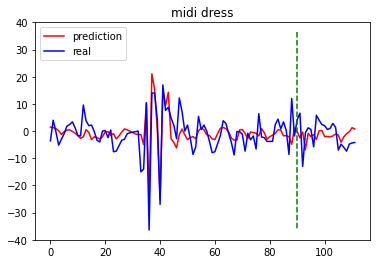

In [ ]:
import os, time, math
import torch
from torch import optim, nn
 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

# -----------------------------------------------------------------------------
# 模型参数
DAYS_FOR_TRAIN = 3
DAYS_TO_PREDICT = 1
NUM_LAYERS = 2
HIDDEN_SIZE = 8
TRAIN_SIZE = 90
PATH = '/content/drive/MyDrive/lab126share/lstm_para/model3_5328_best/'

attributes = ['floral', 'striped', 'plaid', 'leopard', 'camo', 'graphic',
        'crew neck', 'square neck', 'v-neck',
        'maxi dress', 'midi dress', 'mini dress',
        'denim', 'knit', 'faux leather', 'cotton', 'chiffon', 'satin',
        'mesh', 'ruched', 'cutout', 'lace', 'frayed', 'wrap',
        'tropical', 'peasant', 'swim', 'bikini', 'active', 'cargo']

# demo参数
attribute = 'midi dress'
input_path = '/content/drive/MyDrive/lab126share/data/lstm-label.txt'
days_look_back = 5

# -----------------------------------------------------------------------------
## 数据预处理
# data load
raw_data = []
with open(input_path, 'r') as f:
  lines = f.readlines()[:120]
  for line in lines:
    attrs_num = line.rstrip().split(': ')[1].split(' ')
    atrrs_num = [int(x) for x in attrs_num]
    raw_data.append(attrs_num)
all_data = np.array(raw_data, dtype='float32')
all_data = all_data.T

# 相对化
trend_data = []
for data in all_data:
  row = []
  for i in range(len(data) - days_look_back):
    avg = 0
    for j in range(days_look_back):
      avg += data[i+j]
    avg /= days_look_back
    row.append(data[i+days_look_back] - avg)
  trend_data.append(row)
trend_data = np.array(trend_data, dtype='float32')

# 均值化
with open(os.path.join(PATH, f'min_trend.txt'), 'r') as f:
  min_trend = np.array(eval(f.read()), dtype='float32')
  f.close()
trend_norm = ((trend_data + np.reshape(min_trend, (30, 1))) / np.reshape(-min_trend, (30, 1))) + 1
# 反均值化函数（展示用）
def denorm(data, minimum):
  return (data - 1) * (-minimum) - minimum

# create_dataset
def create_dataset(data, days_for_train=5, days_to_predict=1) -> (np.array, np.array):
  dataset_x, dataset_y = [], []
  for i in range(len(data)-days_for_train):
    _x = data[i:(i+days_for_train)]
    dataset_x.append(_x)
    dataset_y.append(data[i+days_for_train+days_to_predict-1]) # 更改days_to_predict可以预测N天后的
  return (np.array(dataset_x), np.array(dataset_y))

index = attributes.index(attribute)
data_x, data_y = create_dataset(trend_norm[index], days_for_train=DAYS_FOR_TRAIN)
data_y = denorm(data_y, min_trend[index])
all_data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
all_data_x = torch.from_numpy(all_data_x)

# -----------------------------------------------------------------------------
# LSTM预测
# practice lstm of pytorch
class LSTM_Regression(nn.Module):
  def __init__(self, input_size, hidden_size, output_size=1, num_layers=2): #【output_size：输出序列长度可以改变】
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(0.5) 

  def forward(self, _x):
    x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
    # x = self.dropout(x)
    s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
    x = x.view(s*b, h)
    x = self.fc(x)
    x = x.view(s, b, -1)  # 把形状改回来
    return x
pred_model = LSTM_Regression(DAYS_FOR_TRAIN, HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS)

# all_data_x = all_data_x.to(device)
# pred_model = pred_model.to(device)

# 最小loss模型
pred_model.load_state_dict(torch.load(os.path.join(PATH, f'{attributes[index]}.pth')))
pred_model.eval()
pred_test = pred_model(all_data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.cpu().view(-1).data.numpy()
pred_test = denorm(pred_test, min_trend[index])

plt.plot(pred_test, 'r', label='prediction')
plt.plot(data_y, 'b', label='real')
plt.plot((TRAIN_SIZE, TRAIN_SIZE), (-min_trend[index], min_trend[index]), 'g--')
plt.legend(loc='best')
plt.title(f'{attributes[index]}')
plt.show()

# 100 epoch
# for epoch in [100, 200, 500]:
#   pred_model.load_state_dict(torch.load(os.path.join(PATH, f'{attributes[index]}_epoch_{epoch}.pth')))
#   pred_model.eval()
#   pred_test = pred_model(all_data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
#   pred_test = pred_test.cpu().view(-1).data.numpy()
#   pred_test = denorm(pred_test, min_trend3[index])

#   plt.plot(pred_test, 'r', label='prediction')
#   plt.plot(data_y, 'b', label='real')
#   plt.plot((TRAIN_SIZE, TRAIN_SIZE), (-min_trend3[index], min_trend3[index]), 'g--')
#   plt.legend(loc='best')
#   plt.title(f'{attributes[index]}_epoch_{epoch}')
#   plt.show()

In [ ]:
days_look_back = 5
trend_data = []
for data in all_data:
  row = []
  for i in range(len(data) - days_look_back):
    avg = 0
    for j in range(days_look_back):
      avg += data[i+j]
    avg /= days_look_back
    row.append(data[i+days_look_back] - avg)
  trend_data.append(row)
trend_data = np.array(trend_data, dtype='float32')
trend_data[:5, :5]

array([[ 10.2,  24.2,  10.2, -10.8,  55. ],
       [ -2.4,   1. ,   4.2,  -2.2,  51.6],
       [  7.4,   2.4,   0.8,   1. ,   2. ],
       [ -1.8,   1.6,   5.6,   1.4,  11.6],
       [  6.8,   4.6,   1.4,   4. ,   4.8]], dtype=float32)

In [ ]:
trend_data5 = []
for data in all_data:
  row = []
  for i in range(len(data) - 5):
    row.append(data[i+5] - (data[i]+data[i+1]+data[i+2]+data[i+3]+data[i+4])/5)
  trend_data5.append(row)
trend_data5 = np.array(trend_data5, dtype='float32')
trend_data5[:5, :5]

array([[ 10.2,  24.2,  10.2, -10.8,  55. ],
       [ -2.4,   1. ,   4.2,  -2.2,  51.6],
       [  7.4,   2.4,   0.8,   1. ,   2. ],
       [ -1.8,   1.6,   5.6,   1.4,  11.6],
       [  6.8,   4.6,   1.4,   4. ,   4.8]], dtype=float32)

# 预测（多日）

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


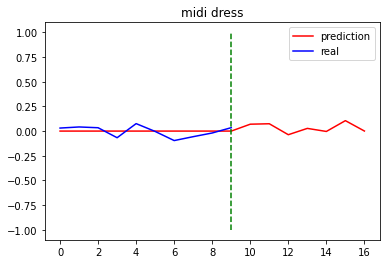

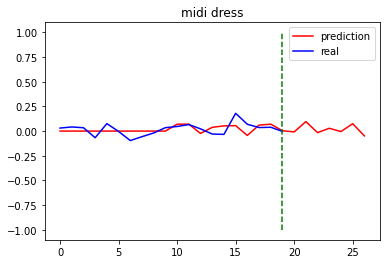

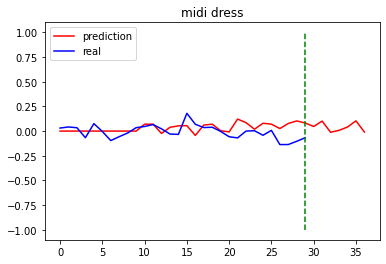

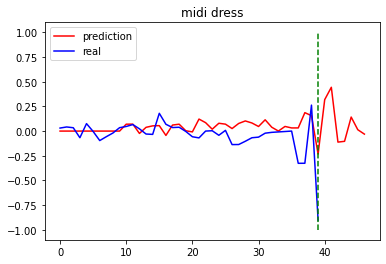

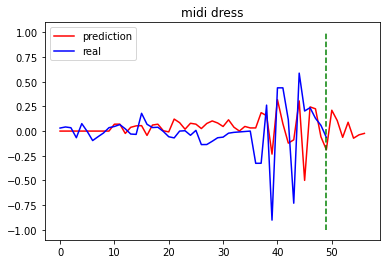

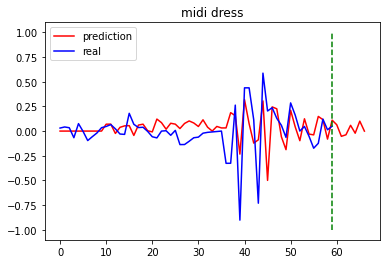

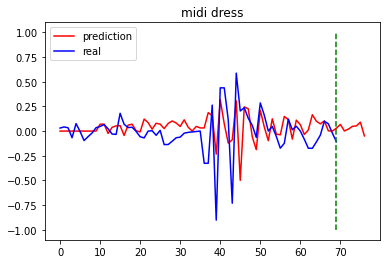

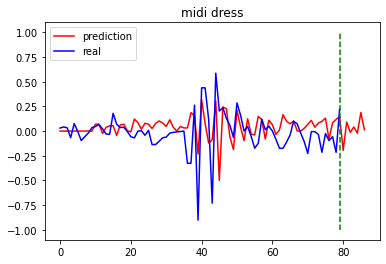

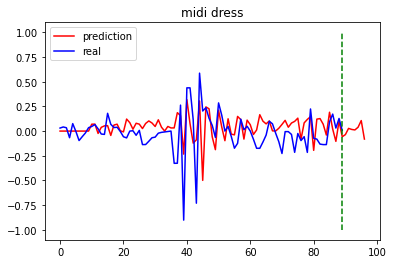

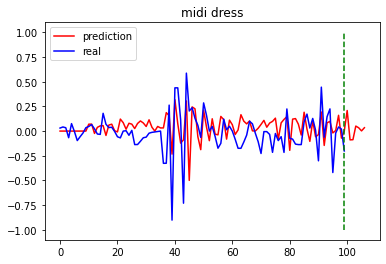

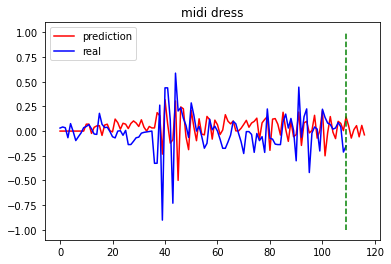

In [ ]:
import os, time, math
import torch
from torch import optim, nn
 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

# -----------------------------------------------------------------------------
# 模型参数
DAYS_FOR_TRAIN = 10
DAYS_TO_PREDICT = 7
NUM_LAYERS = 2
HIDDEN_SIZE = 8
TRAIN_SIZE = 90
PATH = '/content/drive/MyDrive/lab126share/lstm_para/model5_1028_7_best/'

attributes = ['floral', 'striped', 'plaid', 'leopard', 'camo', 'graphic',
        'crew neck', 'square neck', 'v-neck',
        'maxi dress', 'midi dress', 'mini dress',
        'denim', 'knit', 'faux leather', 'cotton', 'chiffon', 'satin',
        'mesh', 'ruched', 'cutout', 'lace', 'frayed', 'wrap',
        'tropical', 'peasant', 'swim', 'bikini', 'active', 'cargo']

# demo参数
attribute = 'midi dress'
input_path = '/content/drive/MyDrive/lab126share/data/lstm-label.txt'
days_look_back = 5

# -----------------------------------------------------------------------------
## 数据预处理
# data load
raw_data = []
with open(input_path, 'r') as f:
  lines = f.readlines()[:120]
  for line in lines:
    attrs_num = line.rstrip().split(': ')[1].split(' ')
    atrrs_num = [int(x) for x in attrs_num]
    raw_data.append(attrs_num)
all_data = np.array(raw_data, dtype='float32')
all_data = all_data.T

# 相对化
trend_data = []
for data in all_data:
  row = []
  for i in range(len(data) - days_look_back):
    avg = 0
    for j in range(days_look_back):
      avg += data[i+j]
    avg /= days_look_back
    row.append((data[i+days_look_back]-avg)/avg)
  trend_data.append(row)
trend_data = np.array(trend_data, dtype='float32')

# # 均值化
# with open(os.path.join(PATH, f'min_trend.txt'), 'r') as f:
#   min_trend = np.array(eval(f.read()), dtype='float32')
#   f.close()
# trend_norm = ((trend_data + np.reshape(min_trend, (30, 1))) / np.reshape(-min_trend, (30, 1))) + 1
# # 反均值化函数（展示用）
# def denorm(data, minimum):
#   return (data - 1) * (-minimum) - minimum

# create_dataset
def create_dataset(data, days_for_train=5, days_to_predict=1) -> (np.array, np.array):
  dataset_x, dataset_y = [], []
  for i in range(len(data)-days_for_train):
    _x = data[i:(i+days_for_train)]
    dataset_x.append(_x)
    dataset_y.append(data[i+days_for_train+days_to_predict-1]) # 更改days_to_predict可以预测N天后的
  return (np.array(dataset_x), np.array(dataset_y))

index = attributes.index(attribute)
data_x, data_y = create_dataset(trend_data[index], days_for_train=DAYS_FOR_TRAIN)
# data_y = denorm(data_y, min_trend[index])
all_data_x = data_x.reshape(-1, 1, DAYS_FOR_TRAIN)
all_data_x = torch.from_numpy(all_data_x)

# -----------------------------------------------------------------------------
# LSTM预测
# practice lstm of pytorch
class LSTM_Regression(nn.Module):
  def __init__(self, input_size, hidden_size, output_size=1, num_layers=2): #【output_size：输出序列长度可以改变】
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(0.5) 

  def forward(self, _x):
    x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
    x = self.dropout(x)
    s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
    x = x.view(s*b, h)
    x = self.fc(x)
    x = x.view(s, b, -1)  # 把形状改回来
    return x
    

pred_model = LSTM_Regression(DAYS_FOR_TRAIN, HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS)

# all_data_x = all_data_x.to(device)
# pred_model = pred_model.to(device)

# 最小loss模型
dynamic_data_fact = all_data_x[0][0][:DAYS_FOR_TRAIN-1].numpy().tolist()
dynamic_data_predict = [0 for i in range(DAYS_FOR_TRAIN+DAYS_TO_PREDICT-1)]
for i in range(len(all_data_x)):
  dynamic_data_fact.append(all_data_x[i][0][-1])
  dynamic_data_predict.append(0)
  for j in range(DAYS_TO_PREDICT):
    pred_model.load_state_dict(torch.load(os.path.join(PATH, f'{attributes[index]}_day{j}.pth')))
    pred_model.eval()
    pred_test = pred_model(all_data_x[i].reshape(-1, 1, 10)) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
    pred_test = pred_test.cpu().view(-1).data.numpy()
    dynamic_data_predict[-DAYS_TO_PREDICT+j] = pred_test

  if i%10 == 0:
    plt.plot(dynamic_data_predict, 'r', label='prediction')
    plt.plot(dynamic_data_fact, 'b', label='real')
    plt.plot((len(dynamic_data_fact)-1, len(dynamic_data_fact)-1), (-1, 1), 'g--')
    plt.legend(loc='best')
    plt.title(f'{attributes[index]}')
    plt.show()

# 100 epoch
# for epoch in [100, 200, 500]:
#   pred_model.load_state_dict(torch.load(os.path.join(PATH, f'{attributes[index]}_epoch_{epoch}.pth')))
#   pred_model.eval()
#   pred_test = pred_model(all_data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
#   pred_test = pred_test.cpu().view(-1).data.numpy()
#   pred_test = denorm(pred_test, min_trend3[index])

#   plt.plot(pred_test, 'r', label='prediction')
#   plt.plot(data_y, 'b', label='real')
#   plt.plot((TRAIN_SIZE, TRAIN_SIZE), (-min_trend3[index], min_trend3[index]), 'g--')
#   plt.legend(loc='best')
#   plt.title(f'{attributes[index]}_epoch_{epoch}')
#   plt.show()

# Class预测（Rate）

In [ ]:
import os, time, math
import torch
from torch import optim, nn
 
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# matplotlib.use('Agg')


from datetime import datetime, timedelta
from dateutil import parser
from copy import copy

# -----------------------------------------------------------------------------
# LSTM预测
# practice lstm of pytorch
class LSTM_Regression(nn.Module):
  def __init__(self, input_size, hidden_size, output_size=1, num_layers=2): #【output_size：输出序列长度可以改变】
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(0.5) 

  def forward(self, _x):
    x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
    x = self.dropout(x)
    s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
    x = x.view(s*b, h)
    x = self.fc(x)
    x = x.view(s, b, -1)  # 把形状改回来
    return x

# -----------------------------------------------------------------------------
class DynamicPredictor():
  '''
  动态预测器
  '''
  def __init__(self, DAYS_FOR_TRAIN, DAYS_TO_PREDICT, DAYS_LOOK_BACK, PATH, attribute_name, init_data, start_date):
    super().__init__()
    self.DAYS_FOR_TRAIN = DAYS_FOR_TRAIN
    self.DAYS_TO_PREDICT = DAYS_TO_PREDICT
    self.DAYS_LOOK_BACK = DAYS_LOOK_BACK
    self.NUM_LAYERS = 2
    self.HIDDEN_SIZE = 8
    self.PATH = PATH

    self.today = parser.parse(start_date) + timedelta(days=len(init_data)-1)
    self.day = len(init_data)
    self.attribute_name = attribute_name
    self.raw_data = init_data
    self.trend_data = []
    for i in range(len(init_data) - self.DAYS_LOOK_BACK):
      avg = 0
      for j in range(self.DAYS_LOOK_BACK):
        avg += init_data[i+j]
      avg /= self.DAYS_LOOK_BACK
      self.trend_data.append((init_data[i+self.DAYS_LOOK_BACK]-avg)/avg)
    
    self.pred_model = [LSTM_Regression(self.DAYS_FOR_TRAIN, self.HIDDEN_SIZE, output_size=1, num_layers=self.NUM_LAYERS) for i in range(self.DAYS_TO_PREDICT)]
    for i in range(self.DAYS_TO_PREDICT):
      self.pred_model[i].load_state_dict(torch.load(os.path.join(self.PATH, f'{self.attribute_name}_day{i}.pth')))
    
    self.predict_data = None
    self.predict()
    # self.predict_data = [0 for i in range(self.DAYS_TO_PREDICT-1)]
    # for i in range(len(self.trend_data)-self.DAYS_FOR_TRAIN+1):
    #   self.append_predict(self.trend_data[i:(i+self.DAYS_FOR_TRAIN)])
  
  def append_data(self, data):
    data = float(data)
    # 相对化
    avg = 0
    for i in range(self.DAYS_LOOK_BACK):
      avg += self.raw_data[-i-1]
    avg /= self.DAYS_LOOK_BACK
    self.trend_data.append((data-avg)/avg)
    self.raw_data.append(data)
    self.today = self.today + timedelta(days=1)
    self.day += 1
    # self.append_predict(self.trend_data[-self.DAYS_FOR_TRAIN:])
    self.predict()
  
  def predict(self):
    data = []
    for i in range(len(self.trend_data)-self.DAYS_FOR_TRAIN+1):
      _x = self.trend_data[i:(i+self.DAYS_FOR_TRAIN)]
      data.append(_x)
    data = torch.tensor(data).reshape(-1, 1, self.DAYS_FOR_TRAIN)
    self.pred_model[0].eval()
    self.predict_data = self.pred_model[0](data).reshape(-1).detach().numpy().tolist()
    for i in range(1, self.DAYS_TO_PREDICT):
      self.pred_model[i].eval()
      pred_test = self.pred_model[i](data[-1:]) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
      pred_test = float(pred_test.cpu().view(-1).data.numpy()[0])
      self.predict_data.append(pred_test)

  # def append_predict(self, data_x):
  #   self.predict_data.append(0)
  #   data_x = torch.tensor(data_x, dtype=torch.float32).reshape(-1, 1, self.DAYS_FOR_TRAIN)
  #   for j in range(self.DAYS_TO_PREDICT):
  #     self.pred_model[j].eval()
  #     pred_test = self.pred_model[j](data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
  #     pred_test = float(pred_test.cpu().view(-1).data.numpy()[0])
  #     self.predict_data[-self.DAYS_TO_PREDICT+j] = pred_test
  
  def plot_prediction(self, trend_len=None):
      plt.figure(figsize=(16, 4))
      if not trend_len:
          trend_len = len(self.trend_data)
      predict_data = copy(self.predict_data[-self.DAYS_TO_PREDICT:])
      predict_data.insert(0, self.trend_data[-1])
      plt.plot(range(trend_len - 1, trend_len + self.DAYS_TO_PREDICT), predict_data, 'r', label='prediction')
      for x, y in zip(range(trend_len - 1, trend_len + self.DAYS_TO_PREDICT), np.array(predict_data)*1.01):
          plt.text(x, y, '{:.2f}'.format(y/1.01))
      plt.plot(self.trend_data[-trend_len:], 'b', label='real')
      plt.plot((trend_len - 1, trend_len - 1), (-0.2, 0.2), 'g--')
      plt.legend(loc='best')
      plt.title('Prediction of {}'.format(self.attribute_name.upper()))
      plt.ylabel("Change Rate to {}-day Avg".format(self.DAYS_LOOK_BACK))
      plt.xlabel('Day')
      # plt.savefig("static/img/test_prediction.jpg", bbox_inches='tight')  # 【修改此处以控制plt的输出位置】
      plt.show()  # 【修改此处以控制plt的输出位置】
      return self.today.strftime('%Y-%m-%d')

  def plot_validation(self, loss_function=nn.MSELoss()):
      plt.figure()
      plt.plot(range(self.DAYS_FOR_TRAIN, len(self.trend_data)), self.predict_data[:-self.DAYS_TO_PREDICT], 'r',
                label='prediction')
      plt.plot(self.trend_data, 'b', label='real')
      plt.legend(loc='best')
      plt.title('Validation of {}'.format(self.attribute_name.upper()))

      if len(range(self.DAYS_FOR_TRAIN, len(self.trend_data))) == 0:
          loss = -1
      else:
          loss = loss_function(torch.tensor(self.predict_data[:-self.DAYS_TO_PREDICT]),
                                torch.tensor(self.trend_data[self.DAYS_FOR_TRAIN:]))
          loss = loss.detach().numpy()
      plt.ylabel("Change Rate to {}-day Avg".format(self.DAYS_LOOK_BACK))
      plt.xlabel('Day\nMSE Loss: {:.6f}'.format(loss))
      # plt.savefig("static/img/test_validation.jpg", bbox_inches='tight')  # 【修改此处以控制plt的输出位置】
      plt.show()  # 【修改此处以控制plt的输出位置】
      return self.today.strftime('%Y-%m-%d'), loss


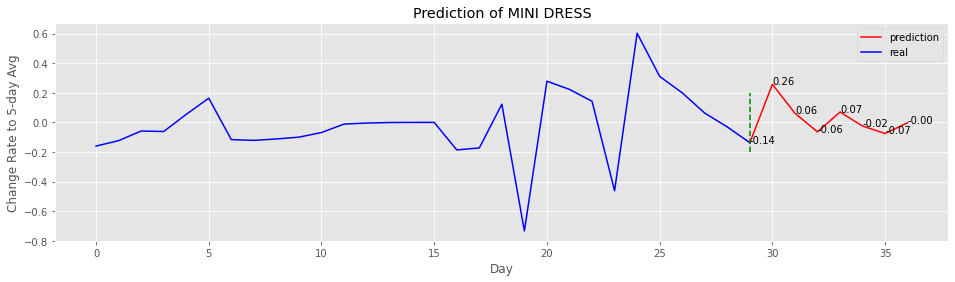

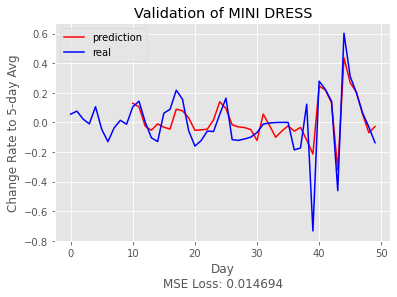

2020-08-11 0.014693948


In [ ]:
# -----------------------------------------------------------------------------
# 主程序
DAYS_FOR_TRAIN = 10
DAYS_TO_PREDICT = 7
NUM_LAYERS = 2
HIDDEN_SIZE = 8
DAYS_LOOK_BACK = 5
PATH = '/content/drive/MyDrive/lab126share/lstm_para/model5_1028_7R_best/'
input_path = '/content/drive/MyDrive/lab126share/data/lstm-label.txt'
attributes = ['floral', 'striped', 'plaid', 'leopard', 'camo', 'graphic',
        'crew neck', 'square neck', 'v-neck',
        'maxi dress', 'midi dress', 'mini dress',
        'denim', 'knit', 'faux leather', 'cotton', 'chiffon', 'satin',
        'mesh', 'ruched', 'cutout', 'lace', 'frayed', 'wrap',
        'tropical', 'peasant', 'swim', 'bikini', 'active', 'cargo']


## 数据预处理
# 【加载预置数据all_data，是一个属性*时间的array，all_data[0][0]表示第0种属性（floral）在第0天的出现次数】
raw_data = []
with open(input_path, 'r') as f:
  lines = f.readlines()[:120]
  for line in lines:
    attrs_num = line.rstrip().split(': ')[1].split(' ')
    atrrs_num = [int(x) for x in attrs_num]
    raw_data.append(attrs_num)
all_data = np.array(raw_data, dtype='float32')
all_data = all_data.T

# 【生成predictor_dict，predictor_dict['floral']指向对floral属性进行预测的预测器，预测器的初始输入是15天（all_data[index][:15]）】
predictor_dict = {}
for index in range(len(attributes)):
  predictor_dict[attributes[index]] = DynamicPredictor(DAYS_FOR_TRAIN, DAYS_TO_PREDICT, DAYS_LOOK_BACK, PATH, attributes[index], all_data[index].tolist()[:DAYS_FOR_TRAIN+DAYS_LOOK_BACK], "2020-06-18")

# 【这个函数调用一次更新一天】
def daily_update(predictor_dict, data, attributes):
  for index in range(len(attributes)):
    key = attributes[index]
    day = predictor_dict[key].day
    predictor_dict[key].append_data(data[index].tolist()[day])
    index += 1

plt.style.use('ggplot')

# 测试时先循环了10天，可以不循环
for _ in range(40):
    daily_update(predictor_dict, all_data, attributes)

# 【绘图部分分成两部分，预测和评估】
# 【attributes[index]就是当前要绘制的属性】
index = 11
# DynamicPredictor.plot_prediction()方法绘制预测的图像，返回值就是日期（string形式） 2020-08-19
date = predictor_dict[attributes[index]].plot_prediction(
    trend_len=min(len(predictor_dict[attributes[index]].trend_data), 30))
# DynamicPredictor.plot_validation()方法绘制评估的图像，返回值是日期（string形式）和当前预测的均方误差（MSELoss） 2020-08-19 0.036840852
date, loss = predictor_dict[attributes[index]].plot_validation()
print(date, loss)


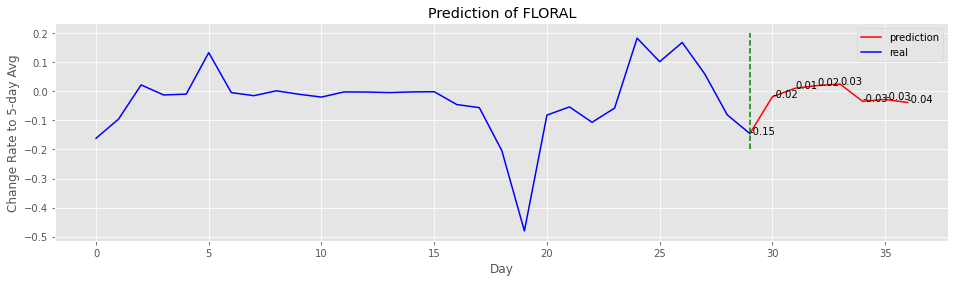

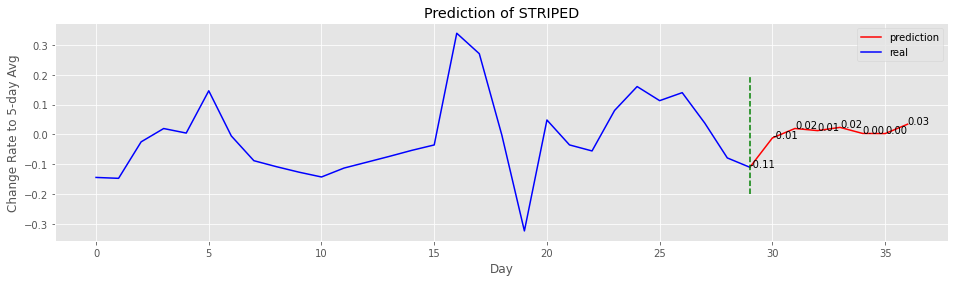

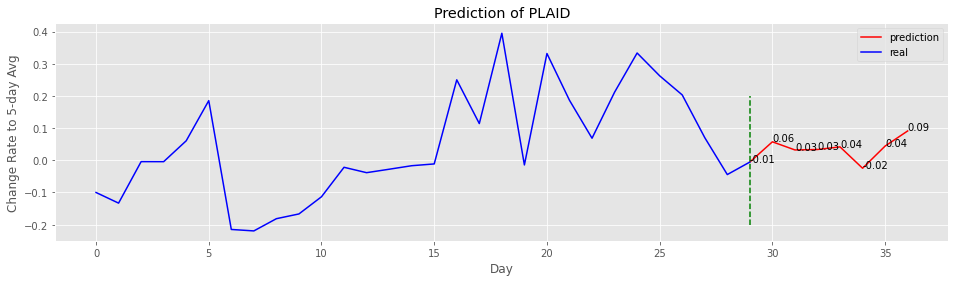

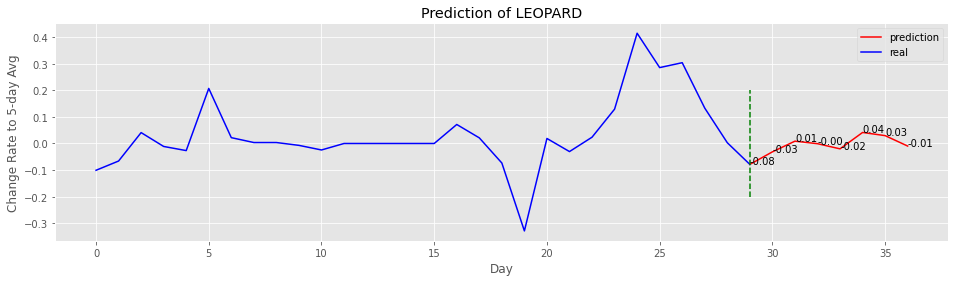

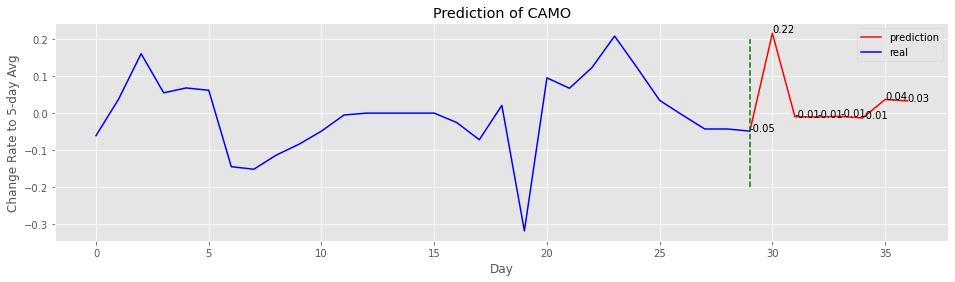

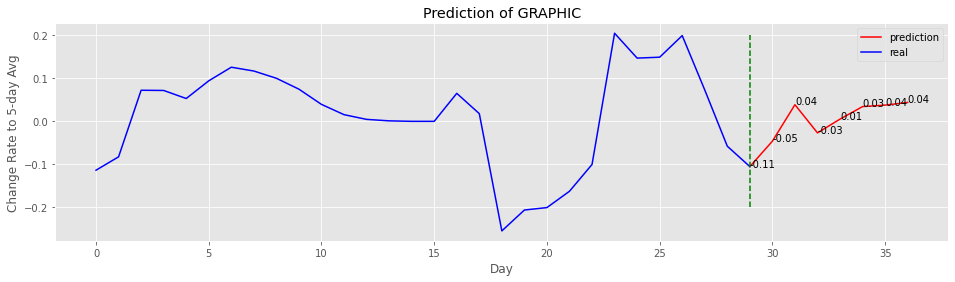

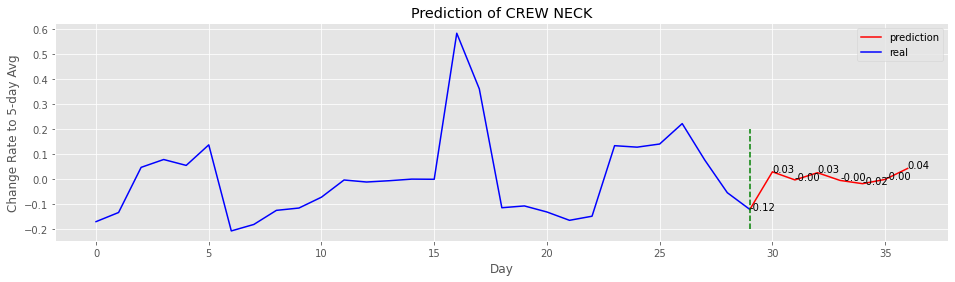

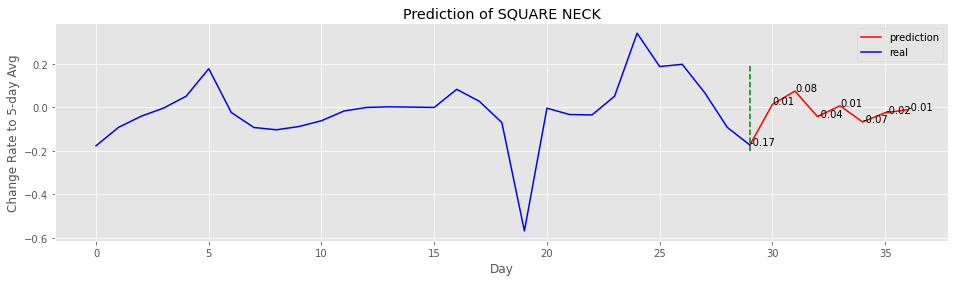

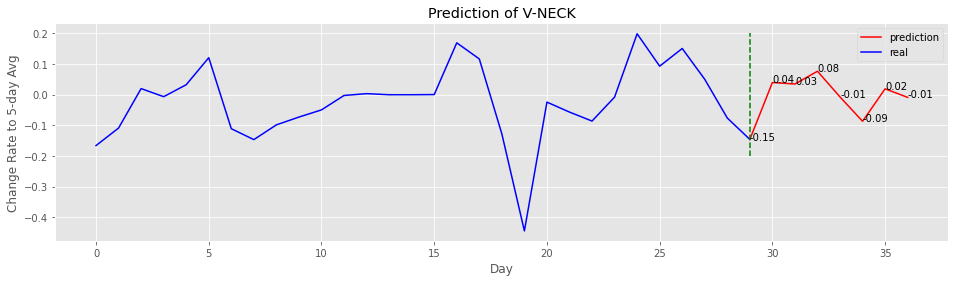

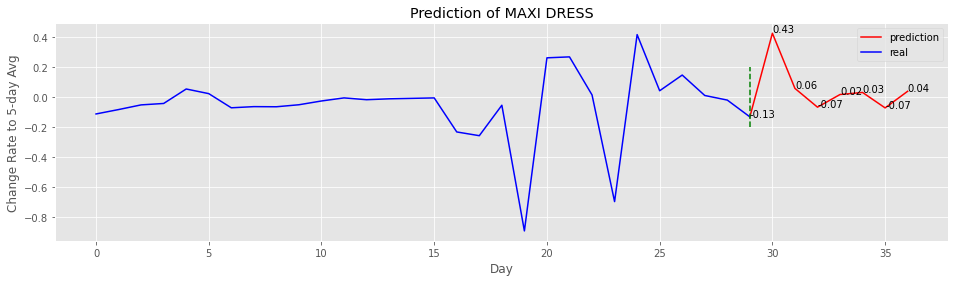

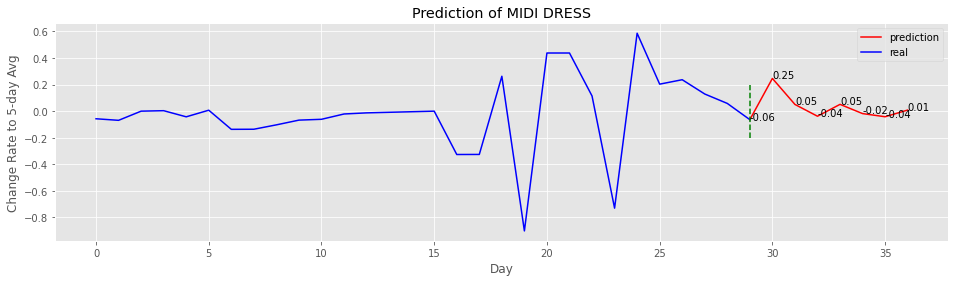

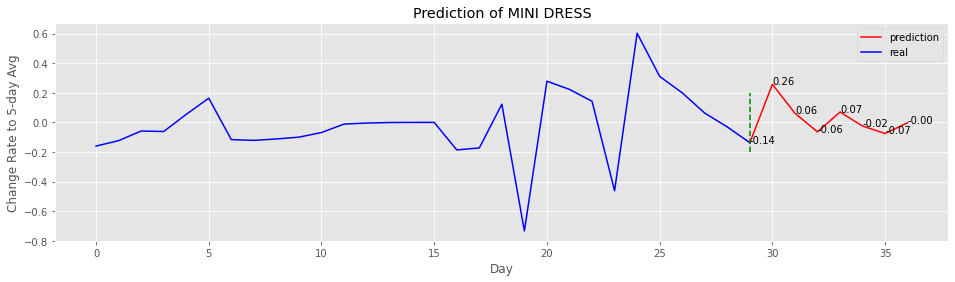

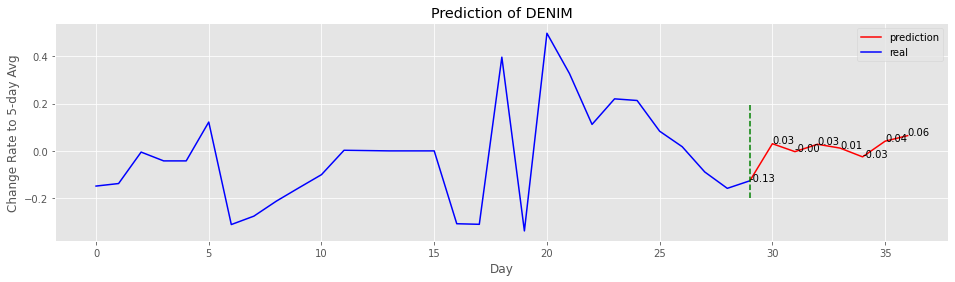

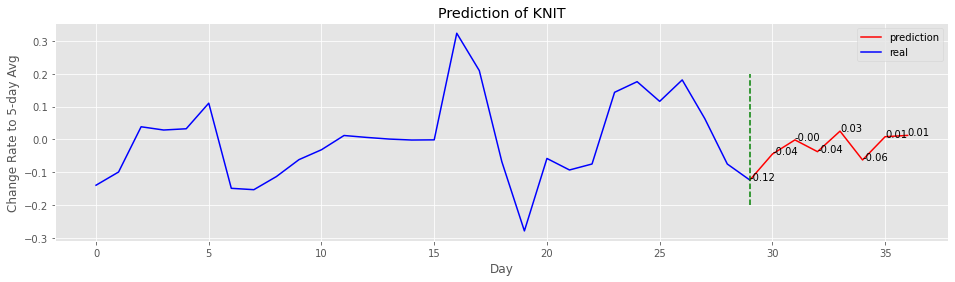

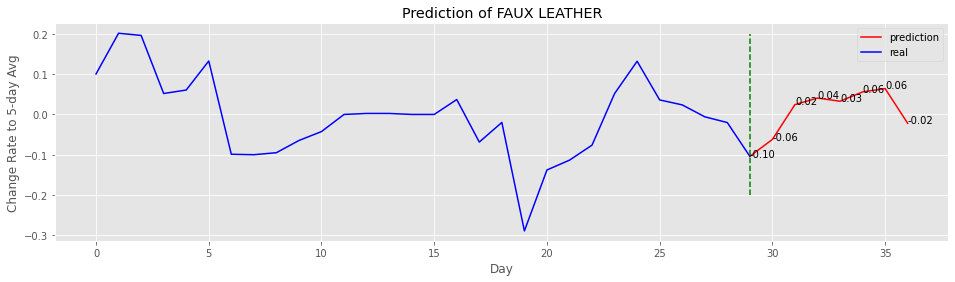

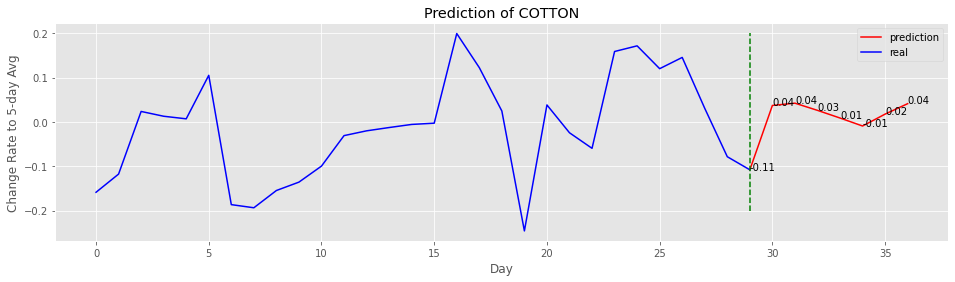

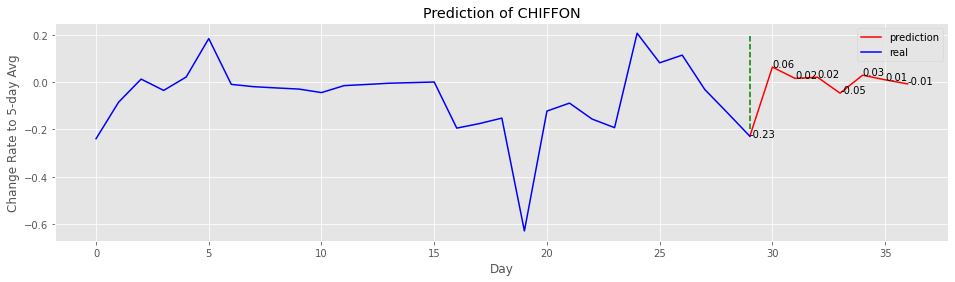

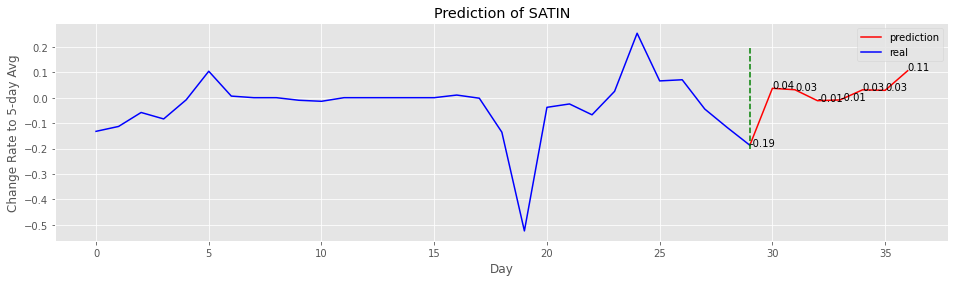

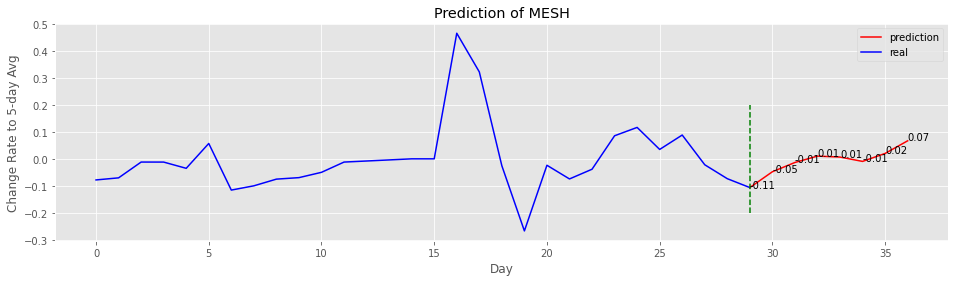

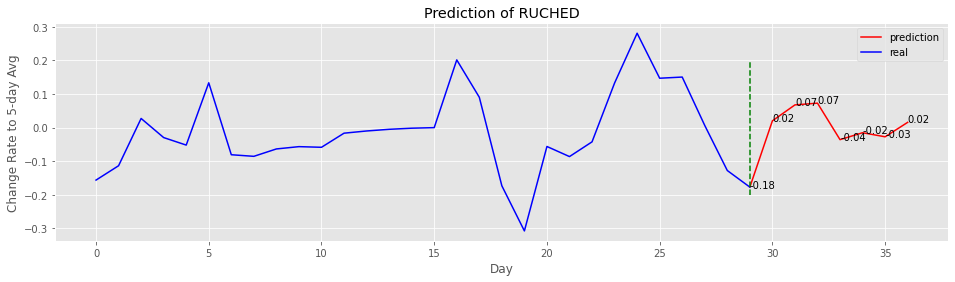

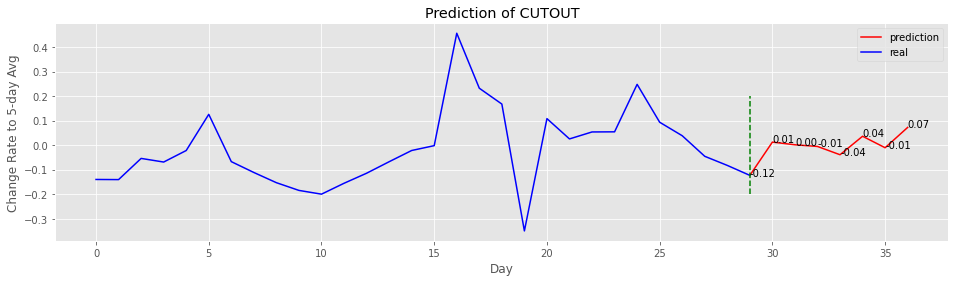

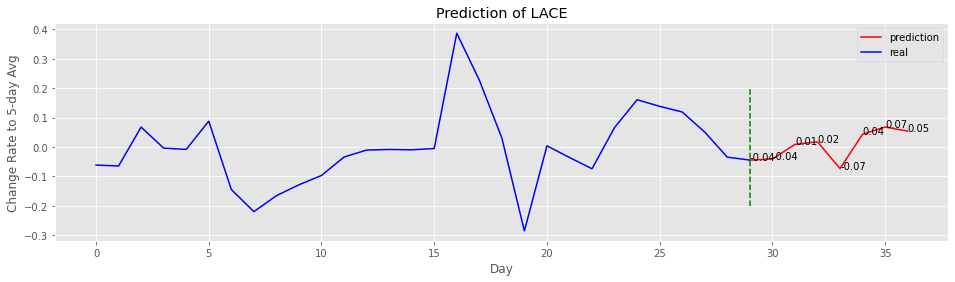

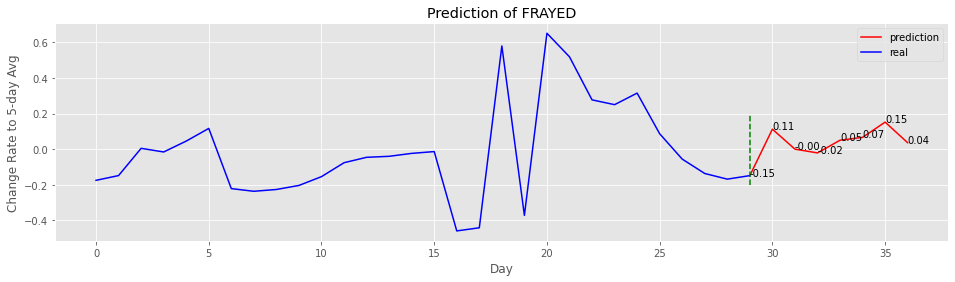

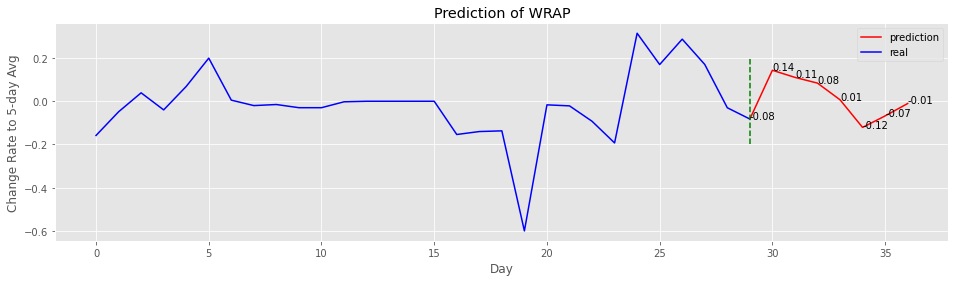

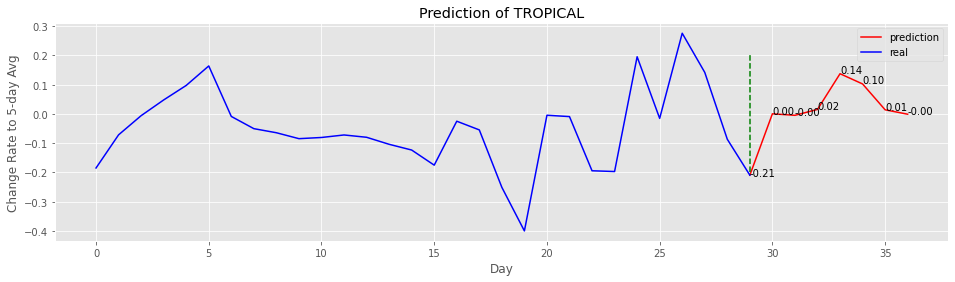

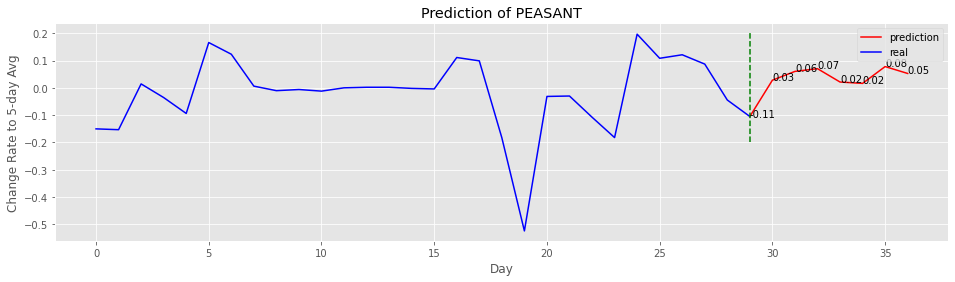

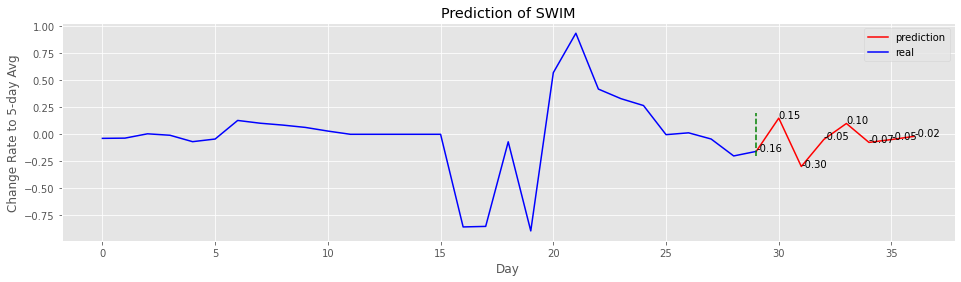

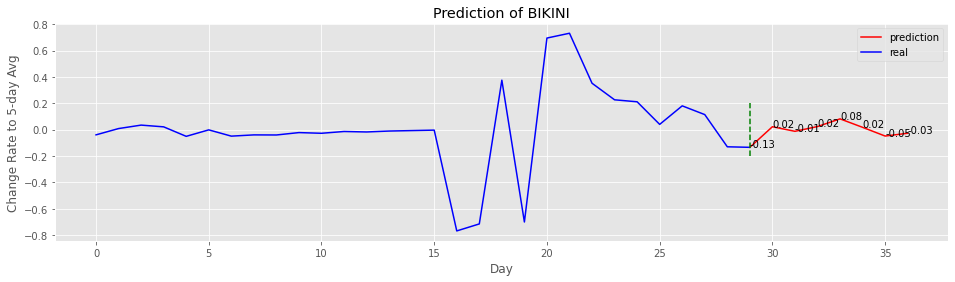

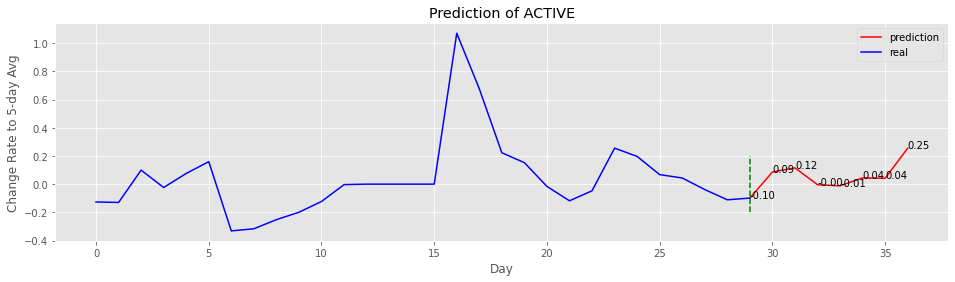

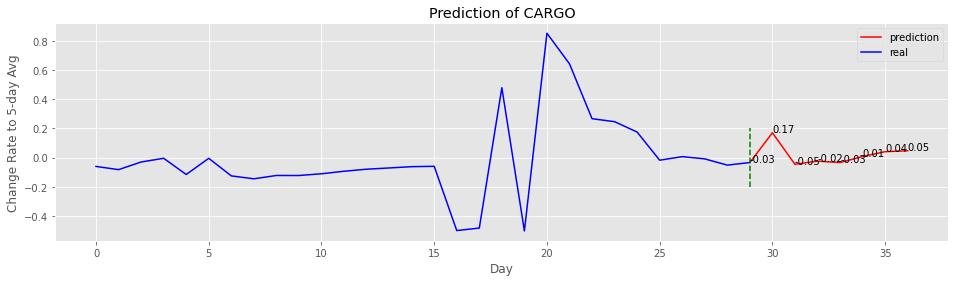

In [ ]:
for attribute in attributes:
  predictor_dict[attribute].plot_prediction(30)

In [ ]:
test = predictor_dict['floral']

In [ ]:
loss_function(torch.tensor(test.trend_data[:10]), torch.tensor(test.predict_data[:10]))

tensor(0.0054)

In [ ]:
self.raw_data[9]

284.0

### 旧代码

In [ ]:
# 旧动态推演-------------------------------------------------------------------
# def _predict():
#     # 【动态推演，每次增加一天的数据并进行绘图】
#     print('start plot!')
#     day = int(request.args.get("day"))
#     mm, dd = 6, 18 + day
#     day += DAYS_FOR_TRAIN + DAYS_LOOK_BACK
#     if day >= len(all_data[0]):
#         return '时间 ： 全部预测完毕'
#     # 【在此处设置暂停点可以控制绘图程序更新频率】
#     for index in range(len(attributes)):
#         predictor_dict[attributes[index]].plot(index + 1)
#         predictor_dict[attributes[index]].append_data(all_data[index].tolist()[day])
#     print('succeed!')
#     tt = [30, 31, 31, 30, 31, 30, 31]
#     for i in range(len(tt)):
#         if dd > tt[i]:
#             dd - tt[i]
#             mm += 1
#         else:
#             break
#     return '时间 ： 2020年%d月%d日' % (mm, dd)



# # 【动态推演，每次增加一天的数据并进行绘图】
# print('start plot!')
# for day in range(DAYS_FOR_TRAIN+DAYS_LOOK_BACK, len(all_data[0])):
#   # 【在此处设置暂停点可以控制绘图程序更新频率】
#   for index in [10]:
#     predictor_dict[attributes[index]].plot()
#     predictor_dict[attributes[index]].append_data(all_data[index].tolist()[day])

# Class预测（Raw）

In [ ]:
import os, time, math
import torch
from torch import optim, nn
 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

# -----------------------------------------------------------------------------
# LSTM预测
# practice lstm of pytorch
class LSTM_Regression(nn.Module):
  def __init__(self, input_size, hidden_size, output_size=1, num_layers=2): #【output_size：输出序列长度可以改变】
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(0.5) 

  def forward(self, _x):
    x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
    x = self.dropout(x)
    s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
    x = x.view(s*b, h)
    x = self.fc(x)
    x = x.view(s, b, -1)  # 把形状改回来
    return x

# -----------------------------------------------------------------------------
class DynamicPredictor():
  '''
  动态预测器
  '''
  def __init__(self, DAYS_FOR_TRAIN, DAYS_TO_PREDICT, DAYS_LOOK_BACK, PATH, attribute_name, init_data, norm_min):
    super().__init__()
    self.DAYS_FOR_TRAIN = DAYS_FOR_TRAIN
    self.DAYS_TO_PREDICT = DAYS_TO_PREDICT
    self.DAYS_LOOK_BACK = DAYS_LOOK_BACK
    self.NUM_LAYERS = 2
    self.HIDDEN_SIZE = 8
    self.PATH = PATH

    self.attribute_name = attribute_name
    self.raw_data = init_data
    self.norm_min = norm_min
    self.trend_data = []
    self.trend_norm = []
    for i in range(len(init_data) - self.DAYS_LOOK_BACK):
      avg = 0
      for j in range(self.DAYS_LOOK_BACK):
        avg += init_data[i+j]
      avg /= self.DAYS_LOOK_BACK
      tmp_trend_data = init_data[i+self.DAYS_LOOK_BACK]-avg
      self.trend_data.append(tmp_trend_data)
      self.trend_norm.append(((tmp_trend_data + self.norm_min) / (-self.norm_min)) + 1)
    
    

    self.pred_model = LSTM_Regression(DAYS_FOR_TRAIN, self.HIDDEN_SIZE, 
                      output_size=1, num_layers=self.NUM_LAYERS)
    
    self.predict_data = [0 for i in range(self.DAYS_TO_PREDICT-1)]
    for i in range(len(self.trend_norm)-self.DAYS_FOR_TRAIN+1):
      self.append_predict(self.trend_norm[i:(i+self.DAYS_FOR_TRAIN)])
  
  def denorm_list(self, data):
    return ((np.array(data) - 1) * (-self.norm_min) - self.norm_min).tolist()

  def append_data(self, data):
    data = float(data)
    # 相对化
    avg = 0
    for i in range(self.DAYS_LOOK_BACK):
      avg += self.raw_data[-i-1]
    avg /= self.DAYS_LOOK_BACK
    self.trend_data.append(data-avg)
    self.trend_norm.append((data-avg+self.norm_min)/(-self.norm_min)+1)
    self.raw_data.append(data)
    self.append_predict(self.trend_norm[-self.DAYS_FOR_TRAIN:])
  
  def append_predict(self, data_x):
    self.predict_data.append(0)
    data_x = torch.tensor(data_x, dtype=torch.float).reshape(-1, 1, self.DAYS_FOR_TRAIN)
    for j in range(self.DAYS_TO_PREDICT):
      self.pred_model.load_state_dict(torch.load(os.path.join(self.PATH, f'{self.attribute_name}_day{j}.pth')))
      self.pred_model.eval()
      pred_test = self.pred_model(data_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
      pred_test = float(pred_test.cpu().view(-1).data.numpy()[0])
      self.predict_data[-self.DAYS_TO_PREDICT+j] = pred_test
  
  def plot(self):
    plt.plot(range(self.DAYS_FOR_TRAIN, len(self.trend_data)+self.DAYS_TO_PREDICT),self.denorm_list(self.predict_data), 'r', label='prediction')
    plt.plot(self.trend_data, 'b', label='real')
    plt.plot((len(self.trend_data)-1, len(self.trend_data)-1), (-self.norm_min, self.norm_min), 'g--')
    plt.legend(loc='best')
    plt.title(f'{self.attribute_name}')
    plt.show() #【修改此处以控制plt的输出位置】

Mounted at /content/drive


In [ ]:
# -----------------------------------------------------------------------------
# 主程序
DAYS_FOR_TRAIN = 10
DAYS_TO_PREDICT = 7
NUM_LAYERS = 2
HIDDEN_SIZE = 8
DAYS_LOOK_BACK = 5
PATH = '/content/drive/MyDrive/lab126share/lstm_para/model5_1028_7_best/'
input_path = '/content/drive/MyDrive/lab126share/data/lstm-label.txt'
attributes = ['floral', 'striped', 'plaid', 'leopard', 'camo', 'graphic',
        'crew neck', 'square neck', 'v-neck',
        'maxi dress', 'midi dress', 'mini dress',
        'denim', 'knit', 'faux leather', 'cotton', 'chiffon', 'satin',
        'mesh', 'ruched', 'cutout', 'lace', 'frayed', 'wrap',
        'tropical', 'peasant', 'swim', 'bikini', 'active', 'cargo']


## 数据预处理
# 【加载预置数据all_data，是一个属性*时间的array，all_data[0][0]表示第0种属性（floral）在第0天的出现次数】
raw_data = []
with open(input_path, 'r') as f:
  lines = f.readlines()[:120]
  for line in lines:
    attrs_num = line.rstrip().split(': ')[1].split(' ')
    atrrs_num = [int(x) for x in attrs_num]
    raw_data.append(attrs_num)
all_data = np.array(raw_data, dtype='float32')
all_data = all_data.T

with open(os.path.join(PATH, f'min_trend.txt'), 'r') as f:
  min_trend = np.array(eval(f.read()), dtype='float32')
  f.close()

# 【生成predictor_dict，predictor_dict['floral']指向对floral属性进行预测的预测器，预测器的初始输入是15天（all_data[index][:15]）】
predictor_dict = {}
for index in range(len(attributes)):
  predictor_dict[attributes[index]] = DynamicPredictor(DAYS_FOR_TRAIN, DAYS_TO_PREDICT, DAYS_LOOK_BACK, PATH, attributes[index], all_data[index].tolist()[:DAYS_FOR_TRAIN+DAYS_LOOK_BACK], min_trend[index])

# 【动态推演，每次增加一天的数据并进行绘图】
print('start plot!')
for day in range(DAYS_FOR_TRAIN+DAYS_LOOK_BACK, len(all_data[0])):
  # 【在此处设置暂停点可以控制绘图程序更新频率】
  for index in range(len(attributes)):
    if day%20 == 0:
      predictor_dict[attributes[index]].plot()
    predictor_dict[attributes[index]].append_data(all_data[index].tolist()[day])

KeyboardInterrupt: ignored

In [ ]:
loss_function = nn.MSELoss()

In [ ]:
trend_data[10]

array([ 0.03053435,  0.04166667,  0.03383459, -0.06716418,  0.0754717 ,
       -0.00369004, -0.09594096, -0.05660377, -0.01923077,  0.03448276,
        0.04651163,  0.06589147,  0.02272727, -0.02985075, -0.03345725,
        0.17977528,  0.06884058,  0.03571429,  0.03873239, -0.00343643,
       -0.05723906, -0.06896552,  0.        ,  0.00352113, -0.04255319,
        0.00719424, -0.13669065, -0.1360294 , -0.10305344, -0.06746032,
       -0.06122449, -0.0212766 , -0.01287554, -0.00862069, -0.004329  ,
        0.        , -0.32608697, -0.3255814 ,  0.26262626, -0.9009901 ,
        0.4375    ,  0.4375    ,  0.11428571, -0.7297297 ,  0.5862069 ,
        0.20320855,  0.23655914,  0.12903225,  0.05820106, -0.06392694,
        0.28504673,  0.16071428,  0.        ,  0.04700855, -0.05349794,
       -0.1733871 , -0.12393162,  0.12107623,  0.01321586,  0.04910714,
        0.        , -0.08296943, -0.17391305, -0.17431192, -0.11057692,
       -0.04040404,  0.09947644,  0.07329843, -0.02061856, -0.10